In [1]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-lm7h4zf6/unsloth_5545d5e24abf49528214a17b820b92ee
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-lm7h4zf6/unsloth_5545d5e24abf49528214a17b820b92ee
  Resolved https://github.com/unslothai/unsloth.git to commit b0781339f035c72b3028d846eb2261e8115cd375
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 128, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 64,
    lora_dropout = 0.1,
    bias = "none",
    use_gradient_checkpointing = True, # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2024.5 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


### Prepare dataset

In [4]:
from huggingface_hub import login

In [5]:
login()

In [6]:
from datasets import load_dataset

# Used https://huggingface.co/datasets/cmu_hinglish_dog dataset
# converted it to usable format and then uploaded into my private repo

dataset = load_dataset("suyash2739/Hinglish",split='train')

In [7]:
dataset

Dataset({
    features: ['output', 'input'],
    num_rows: 8060
})

In [8]:
prompt = """Translate the input from English to Hinglish to give the response.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for  input, output in zip( inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass


In [9]:
dataset = load_dataset("suyash2739/Hinglish",split='train')
dataset = dataset.map(formatting_prompts_func, batched = True,)
dataset

Dataset({
    features: ['output', 'input', 'text'],
    num_rows: 8060
})

In [10]:
dataset['text']

['Translate the input from English to Hinglish to give the response.\n\n### Input:\nhi\n\n### Response:\nhi<|eot_id|>',
 'Translate the input from English to Hinglish to give the response.\n\n### Input:\nwhat moviie did you see\n\n### Response:\ntumne konsi movie dekhi<|eot_id|>',
 'Translate the input from English to Hinglish to give the response.\n\n### Input:\nhello how are you? Have you heard of Batman Begins? It is a great movie!\n\n### Response:\nhello tum kaise ho? Kya tumne Batman Begins ke bare mein suna hai? Kya great movie hai!<|eot_id|>',
 'Translate the input from English to Hinglish to give the response.\n\n### Input:\nno tell me more\n\n### Response:\nnahi aur batao<|eot_id|>',
 'Translate the input from English to Hinglish to give the response.\n\n### Input:\nwhat is it about\n\n### Response:\nye kis bare mein hai<|eot_id|>',
 'Translate the input from English to Hinglish to give the response.\n\n### Input:\nIt stars Christian Bale, Michael Caine, and Liam Neeson. Great

In [11]:
eval_dataset = load_dataset("suyash2739/Hinglish",split='test')
eval_dataset = dataset.map(formatting_prompts_func, batched = True,)
eval_dataset

Dataset({
    features: ['output', 'input', 'text'],
    num_rows: 8060
})

### Set trainer

In [12]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    eval_dataset= eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    compute_metrics= None,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        num_train_epochs=3,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

In [13]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
6.699 GB of memory reserved.


### Train the model

In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 8,060 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 8
\        /    Total batch size = 32 | Total steps = 753
 "-____-"     Number of trainable parameters = 335,544,320


In [16]:
evaluate_stats=trainer.evaluate()

In [17]:
evaluate_stats

{'eval_loss': 0.7847753167152405,
 'eval_runtime': 400.9437,
 'eval_samples_per_second': 20.103,
 'eval_steps_per_second': 2.514,
 'epoch': 2.989578163771712}

In [18]:
trainer_stats

TrainOutput(global_step=753, training_loss=1.2023904081359802, metrics={'train_runtime': 4960.1539, 'train_samples_per_second': 4.875, 'train_steps_per_second': 0.152, 'total_flos': 9.500202191978496e+16, 'train_loss': 1.2023904081359802, 'epoch': 2.989578163771712})

In [19]:
trainer.state.log_history

[{'loss': 3.8425,
  'grad_norm': 2.2922215461730957,
  'learning_rate': 2e-05,
  'epoch': 0.003970223325062035,
  'step': 1},
 {'loss': 3.9281,
  'grad_norm': 3.122206449508667,
  'learning_rate': 4e-05,
  'epoch': 0.00794044665012407,
  'step': 2},
 {'loss': 3.7335,
  'grad_norm': 2.6502513885498047,
  'learning_rate': 6e-05,
  'epoch': 0.011910669975186104,
  'step': 3},
 {'loss': 3.3153,
  'grad_norm': 1.6958870887756348,
  'learning_rate': 8e-05,
  'epoch': 0.01588089330024814,
  'step': 4},
 {'loss': 3.0988,
  'grad_norm': 2.025275945663452,
  'learning_rate': 0.0001,
  'epoch': 0.019851116625310174,
  'step': 5},
 {'loss': 2.5777,
  'grad_norm': 2.2442030906677246,
  'learning_rate': 9.986631016042781e-05,
  'epoch': 0.02382133995037221,
  'step': 6},
 {'loss': 2.1906,
  'grad_norm': 2.1447043418884277,
  'learning_rate': 9.973262032085562e-05,
  'epoch': 0.027791563275434243,
  'step': 7},
 {'loss': 2.0867,
  'grad_norm': 1.1038589477539062,
  'learning_rate': 9.959893048128343e

In [20]:
data=trainer.state.log_history
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(data)
df


loss  grad_norm  learning_rate     epoch  step  train_runtime  \
0    3.8425   2.292222   2.000000e-05  0.003970     1            NaN   
1    3.9281   3.122206   4.000000e-05  0.007940     2            NaN   
2    3.7335   2.650251   6.000000e-05  0.011911     3            NaN   
3    3.3153   1.695887   8.000000e-05  0.015881     4            NaN   
4    3.0988   2.025276   1.000000e-04  0.019851     5            NaN   
..      ...        ...            ...       ...   ...            ...   
750  0.9073   0.816672   2.673797e-07  2.981638   751            NaN   
751  0.8504   0.829377   1.336898e-07  2.985608   752            NaN   
752  0.8720   0.841114   0.000000e+00  2.989578   753            NaN   
753     NaN        NaN            NaN  2.989578   753      4960.1539   
754     NaN        NaN            NaN  2.989578   753            NaN   

     train_samples_per_second  train_steps_per_second    total_flos  \
0                         NaN                     NaN           NaN   
1                         NaN                     NaN           NaN   
2                         NaN                     NaN           NaN   
3                         NaN                     NaN           NaN   
4                         NaN                     NaN           NaN   
..                        ...                     ...           ...   
750                       NaN                     NaN           NaN   
751                       NaN                     NaN           NaN   
752                       NaN                     NaN           NaN   
753                     4.875                   0.152  9.500202e+16   
754                       NaN                     NaN           NaN   

     train_loss  eval_loss  eval_runtime  eval_samples_per_second  \
0           NaN        NaN           NaN                      NaN   
1           NaN        NaN           NaN                      NaN   
2           NaN        NaN           NaN                      NaN   
3           NaN        NaN           NaN                      NaN   
4           NaN        NaN           NaN                      NaN   
..          ...        ...           ...                      ...   
750         NaN        NaN           NaN                      NaN   
751         NaN        NaN           NaN                      NaN   
752         NaN        NaN           NaN                      NaN   
753     1.20239        NaN           NaN                      NaN   
754         NaN   0.784775      400.9437                   20.103   

     eval_steps_per_second  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
..                     ...  
750                    NaN  
751                    NaN  
752                    NaN  
753                    NaN  
754                  2.514  

[755 rows x 14 columns]

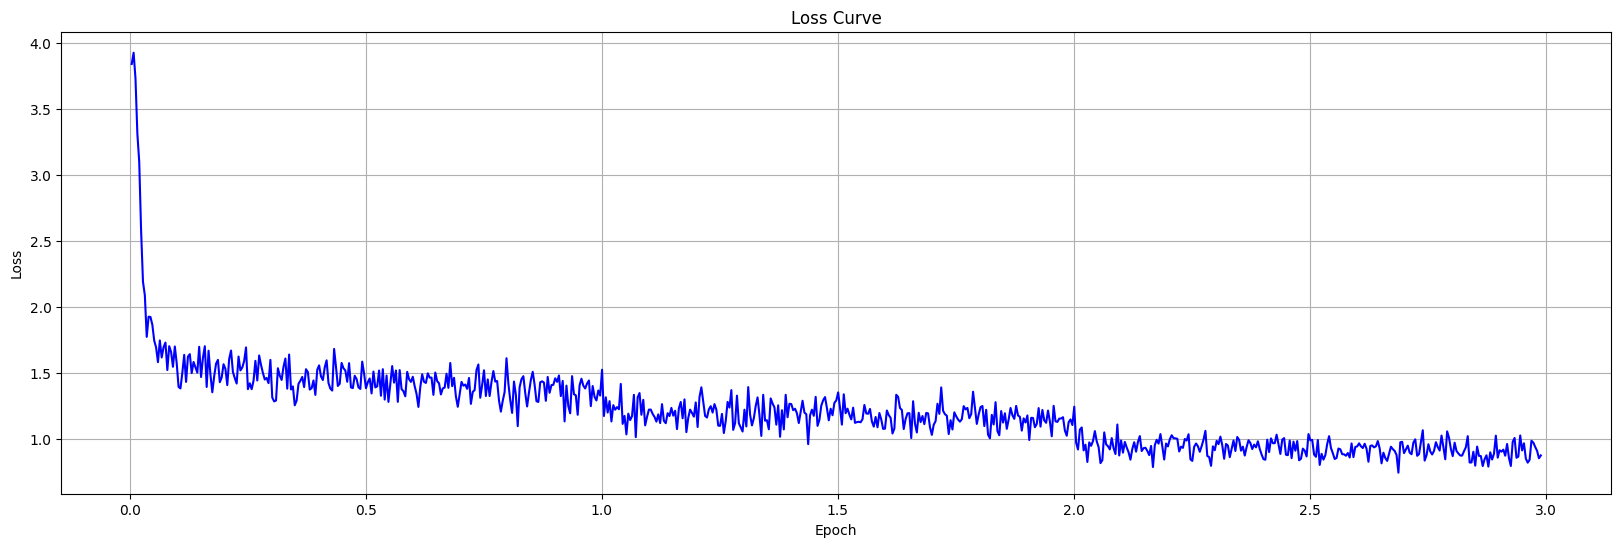

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(df['epoch'], df['loss'], linestyle='-', color='b')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [22]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

4960.1539 seconds used for training.
82.67 minutes used for training.
Peak reserved memory = 16.365 GB.
Peak reserved memory for training = 9.666 GB.
Peak reserved memory % of max memory = 73.823 %.
Peak reserved memory for training % of max memory = 43.603 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [23]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    prompt.format(
        "Interglobe Aviation is currently trading at ₹4306.30, up by 157.85 points or 3.81% from its previous closing of ₹4148.45 on the BSE. The scrip opened at ₹4167.85 and touched a high and low of ₹4313.75 and ₹4133.35 respectively. So far 32998 shares have been traded on the counter.", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 2048, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>Translate the input from English to Hinglish to give the response.\n\n### Input:\nInterglobe Aviation is currently trading at ₹4306.30, up by 157.85 points or 3.81% from its previous closing of ₹4148.45 on the BSE. The scrip opened at ₹4167.85 and touched a high and low of ₹4313.75 and ₹4133.35 respectively. So far 32998 shares have been traded on the counter.\n\n### Response:\nInterglobe Aviation abhi trading kar raha hai ₹4306.30, up by 157.85 points or 3.81% from its previous closing of ₹4148.45 on the BSE. The scrip opened at ₹4167.85 and touched a high and low of ₹4313.75 and ₹4133.35 respectively. abhi tak 32998 shares have been traded on the counter.<|eot_id|>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [24]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
  prompt.format(
        """Finance Minister Nirmala Sitharaman said, "There used to be a poverty index...a human development index and all of them continue, but today what is keenly watched is VIX, the volatility index of the markets." Stability of the government is important for markets to be efficient, she stated. PM Narendra Modi's third term will make markets function with stability, she added.""", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 2048)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Translate the input from English to Hinglish to give the response.

### Input:
Finance Minister Nirmala Sitharaman said, "There used to be a poverty index...a human development index and all of them continue, but today what is keenly watched is VIX, the volatility index of the markets." Stability of the government is important for markets to be efficient, she stated. PM Narendra Modi's third term will make markets function with stability, she added.

### Response:
Finance Minister Nirmala Sitharaman ne kaha, "poverty index...human development index sab chale the, lekin aaj kal jo keenly watch kiya jata hai wo VIX hai, markets ki volatility index." Government ki stability markets ko efficient bana deta hai, usne statement ki. PM Narendra Modi ki third term markets ko stability se function karegi, usne add ki.<|eot_id|>
